https://www.kaggle.com/bobazooba/thousands-of-questions-about-love

In [2]:
import os
import re
import nltk
import umap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn import model_selection
import matplotlib.patches as mpatches
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
import smart_open
smart_open.open = smart_open.smart_open
import gensim
import gensim.downloader as gensim_api
import multiprocessing

/Users/nikita/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
from tensorflow.keras import models, layers, preprocessing as kprocessing, Sequential

ModuleNotFoundError: No module named 'tensorflow'

Функция для преобразования текста (удаление стоп-слов, стемминг и лемматизация):

In [5]:
def normalize(text):
    words = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    
    sw = stopwords.words('english')
    lst_text = [word for word in words if word not in sw][:501]
    
    # Стемминг
    ps = nltk.stem.porter.PorterStemmer()
    words = [ps.stem(word) for word in words]

    # Лемматизация
    # lem = nltk.stem.wordnet.WordNetLemmatizer()
    # words = [lem.lemmatize(word) for word in words]

    return " ".join(words)

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/nikita/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
love = pd.read_json("../resources/love.jsonl", lines=True)[['question', 'comment', 'sub_category']]
#love["text"] = love["question"] + love["comment"]
#love['text'] = love[['question', 'comment']].agg(' '.join, axis=1)
love = love.replace("", float("NaN")).dropna().drop_duplicates(ignore_index=True)
love

,question,comment,sub_category
0,С мужчиной не видимся,Поснакомились с мужчиной месяц назад. Интересн...,relations
1,"30 лет для 33 летнего мужика, это очень старая...","даже если ее и не любит, а как инкубатор?",relations
2,Нормально ли поведение мужчины?,"Нормально ли поведение мужчины,?!Написал снача...",relations
3,Почему один парень на работе ни с того ни с се...,При этом других не трогает и она на него тоже ...,relations
4,Почему женщины не могут понять одну истину...?,"В последнее время часто встречаются женщины, к...",relations
...,...,...,...
38554,Здравствуйте! Что делать? Объясните,"Короче моя подруга сегодня сказала, что я стра...",friendship
38555,Как понять нравлюсь ли я парню?,Мы учимся в одной группе. Иногда общаемся... Ч...,friendship
38556,есть привычка отбирать людей по статусу и поло...,"как бы сказать, мне приятно общаться с богатым...",friendship
38557,"Как назвать человека, который помогает, даде е...","Не согу вспомнить слово, вот ситуация, тебе ну...",friendship


In [7]:
love['sub_category'].unique()

array(['relations', 'love_other', 'loving', 'divorsing', 'dating',
       'friendship'], dtype=object)

In [8]:
love["cleaned"] = love.comment.apply(lambda text: normalize(text))
love

,question,comment,sub_category,cleaned
0,С мужчиной не видимся,Поснакомились с мужчиной месяц назад. Интересн...,relations,поснакомились с мужчиной месяц назад интересно...
1,"30 лет для 33 летнего мужика, это очень старая...","даже если ее и не любит, а как инкубатор?",relations,даже если ее и не любит а как инкубатор
2,Нормально ли поведение мужчины?,"Нормально ли поведение мужчины,?!Написал снача...",relations,нормально ли поведение мужчины написал сначала...
3,Почему один парень на работе ни с того ни с се...,При этом других не трогает и она на него тоже ...,relations,при этом других не трогает и она на него тоже ...
4,Почему женщины не могут понять одну истину...?,"В последнее время часто встречаются женщины, к...",relations,в последнее время часто встречаются женщины ко...
...,...,...,...,...
38554,Здравствуйте! Что делать? Объясните,"Короче моя подруга сегодня сказала, что я стра...",friendship,короче моя подруга сегодня сказала что я стран...
38555,Как понять нравлюсь ли я парню?,Мы учимся в одной группе. Иногда общаемся... Ч...,friendship,мы учимся в одной группе иногда общаемся часто...
38556,есть привычка отбирать людей по статусу и поло...,"как бы сказать, мне приятно общаться с богатым...",friendship,как бы сказать мне приятно общаться с богатыми...
38557,"Как назвать человека, который помогает, даде е...","Не согу вспомнить слово, вот ситуация, тебе ну...",friendship,не согу вспомнить слово вот ситуация тебе нужн...


In [11]:
train, test = model_selection.train_test_split(love, test_size=0.2)

In [12]:
corpus = train["cleaned"]

# Сформируем список юниграмм
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

Обучаем модель Word2Vec для построения вложений слов:

In [13]:
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, vector_size=20,   
            window=8, min_count=1, sg=1, epochs=10)

In [36]:
len(nlp.wv)

89842

Преобразование текста в вектор чисел на основе построенных с помощью word2Vec вложений слов:

In [37]:
def text_to_vec(text):
    words = text.split(" ")
    vec = [nlp.wv[word] for word in words if word in nlp.wv]
    return np.asarray(vec).reshape(-1)

In [38]:
love["vec"] = love.cleaned.apply(lambda text: text_to_vec(text))

In [39]:
love

,question,comment,sub_category,cleaned,vec
0,С мужчиной не видимся,Поснакомились с мужчиной месяц назад. Интересн...,relations,поснакомились с мужчиной месяц назад интересно...,"[-0.17903478, 0.10804388, 0.06980011, 0.161676..."
1,"30 лет для 33 летнего мужика, это очень старая...","даже если ее и не любит, а как инкубатор?",relations,даже если ее и не любит а как инкубатор,"[-0.39792132, -0.16541009, 0.5258626, 0.222253..."
2,Нормально ли поведение мужчины?,"Нормально ли поведение мужчины,?!Написал снача...",relations,нормально ли поведение мужчины написал сначала...,"[-0.3345897, 0.04210544, 0.68189746, 0.7512285..."
3,Почему один парень на работе ни с того ни с се...,При этом других не трогает и она на него тоже ...,relations,при этом других не трогает и она на него тоже ...,"[-0.42846337, -0.41930965, 0.99574304, -0.6748..."
4,Почему женщины не могут понять одну истину...?,"В последнее время часто встречаются женщины, к...",relations,в последнее время часто встречаются женщины ко...,"[-0.6008906, -0.3628703, 0.6306512, 0.16436002..."
...,...,...,...,...,...
38554,Здравствуйте! Что делать? Объясните,"Короче моя подруга сегодня сказала, что я стра...",friendship,короче моя подруга сегодня сказала что я стран...,"[-0.39797184, -0.31703982, 0.66773677, 0.24502..."
38555,Как понять нравлюсь ли я парню?,Мы учимся в одной группе. Иногда общаемся... Ч...,friendship,мы учимся в одной группе иногда общаемся часто...,"[-0.35531196, -0.16346292, 0.67750835, 0.59234..."
38556,есть привычка отбирать людей по статусу и поло...,"как бы сказать, мне приятно общаться с богатым...",friendship,как бы сказать мне приятно общаться с богатыми...,"[-0.3479782, -0.11899534, 0.49059847, 0.277900..."
38557,"Как назвать человека, который помогает, даде е...","Не согу вспомнить слово, вот ситуация, тебе ну...",friendship,не согу вспомнить слово вот ситуация тебе нужн...,"[-0.27697462, 0.165904, 0.5538932, 0.22008349,..."


Выравниваем все векторизованные тексты по длине:

In [40]:
max_words = max(love.vec.apply(lambda vec: len(vec)))
max_words

14360

In [43]:
pad_data = kprocessing.sequence.pad_sequences(
    love.vec, 
    maxlen=max_words, 
    padding="post", 
    truncating="post",
    dtype="float32"
)

NameError: name 'kprocessing' is not defined

Проецируем тексты на двумерное пространство UMAP'ом:

In [46]:
fit = umap.UMAP(
    n_neighbors=50,
    min_dist=0.01,
    n_components=2,
    metric="euclidean",
    random_state=42
)
    
umap_result = fit.fit_transform(love.vec)

ValueError: setting an array element with a sequence.

Отображаем результат проекции:

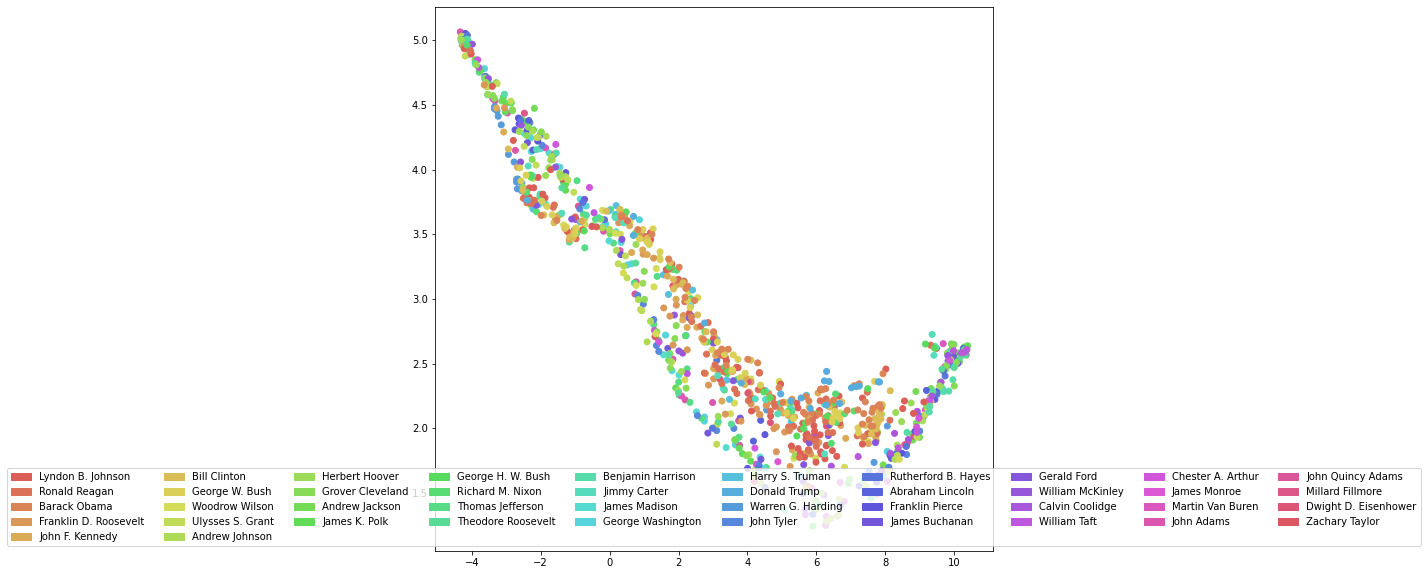

In [18]:
keys = list(love["sub_category"].value_counts().keys())
themes_dict = {keys[i]:i for i in range(len(keys))}
colors = [sns.color_palette("hls", len(themes_dict))[x] for x in love["sub_category"].map(themes_dict)]

fig = plt.figure(figsize=(10, 10))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=colors)

patches = [mpatches.Patch(color=sns.color_palette("hls", len(themes_dict))[i], label=keys[i]) for i in range(len(keys))]
plt.legend(handles=patches, ncol=10, loc="lower center")

Преобразуем тексты в виде n-грамм в последовательности индексов слов в матрице вложений:

In [30]:
train, test = model_selection.train_test_split(speeches, test_size=0.2)
test.president.value_counts()

Lyndon B. Johnson        16
Ronald Reagan            14
Barack Obama             10
Franklin D. Roosevelt    10
John F. Kennedy           9
George W. Bush            8
Herbert Hoover            7
George H. W. Bush         7
Woodrow Wilson            7
Donald Trump              6
James K. Polk             6
Warren G. Harding         6
Thomas Jefferson          6
Bill Clinton              6
George Washington         6
Calvin Coolidge           6
Grover Cleveland          6
Theodore Roosevelt        5
William McKinley          5
James Madison             4
James Monroe              4
Andrew Johnson            4
Franklin Pierce           4
Andrew Jackson            4
Benjamin Harrison         3
Richard M. Nixon          3
Martin Van Buren          3
William Taft              3
John Tyler                3
Ulysses S. Grant          2
Harry S. Truman           2
Rutherford B. Hayes       2
Zachary Taylor            2
Abraham Lincoln           2
James Buchanan            2
John Adams          

In [31]:
x_train = kprocessing.sequence.pad_sequences(
    train.vec, 
    maxlen=max_words, 
    padding="post", 
    truncating="post"
)

Составляем n-граммы для тестовой выборки:

In [32]:
# Выравнивание по длине
x_test = kprocessing.sequence.pad_sequences(
    test.vec, 
    maxlen=max_words,
    padding="post", 
    truncating="post"
)

Строим матрицу вложений размером <число_слов> * <длина_вложения_слова>:

In [43]:
max_words = max(speeches.vec.apply(lambda vec: len(vec)))
num_classes = len(np.unique(speeches.president))

In [44]:
model = Sequential()
model.add(layers.Dense(512, input_shape=(max_words,)))
model.add(layers.Activation('relu'))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               339712512 
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 42)                21546     
_________________________________________________________________
activation_3 (Activation)    (None, 42)                0         
Total params: 339,734,058
Trainable params: 339,734,058
Non-trainable params: 0
_________________________________________________________________


In [45]:
y_train = train["president"].values
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

y_test = test["president"].values
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_test))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_test = np.array([inverse_dic[y] for y in y_test])

In [47]:
training = model.fit(x=x_train, y=y_train, batch_size=50, 
                     epochs=20, shuffle=True, verbose=0, 
                     validation_split=0.3)

In [48]:
res = list(map(lambda x: list(x).index(max(x)), model.predict(x_test)))
print(classification_report(y_test, res))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         4
           2       0.14      0.75      0.23         4
           3       0.11      0.30      0.16        10
           4       0.22      0.67      0.33         3
           5       0.03      0.17      0.06         6
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         7
          12       0.07      0.25      0.11         8
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         6
          16       0.00      0.00      0.00         2
          17       0.00    

C:\Users\IksaritsaNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\IksaritsaNI\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
